In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import random

In [2]:
!git clone https://gitlab.com/adrian.imb94/ImageSegmentation.git

Cloning into 'ImageSegmentation'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 153 (delta 16), reused 149 (delta 13), pack-reused 0
Receiving objects: 100% (153/153), 242.55 MiB | 29.50 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (113/113), done.


In [4]:
cd ImageSegmentation/


SyntaxError: ignored

In [5]:
!python setup.py install


running install
running bdist_egg
running egg_info
creating UNKNOWN.egg-info
writing UNKNOWN.egg-info/PKG-INFO
writing dependency_links to UNKNOWN.egg-info/dependency_links.txt
writing top-level names to UNKNOWN.egg-info/top_level.txt
writing manifest file 'UNKNOWN.egg-info/SOURCES.txt'
writing manifest file 'UNKNOWN.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying UNKNOWN.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying UNKNOWN.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying UNKNOWN.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying UNKNOWN.egg-info/top_level.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
zip_safe flag not set; analyzing archive contents...
creating dist
creating 'dist/UNKNOWN-0.0.0-py3.7.egg' and adding 'build/bdi

In [6]:
ROOT_DIR = '/content/ImageSegmentation'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR no existe.'

sys.path.append(ROOT_DIR) 

from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [7]:
# Directorio para guardar logs y modelos
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path a modelos entrenados
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [8]:
class CustomConfig(Config):
    NAME = "object"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 2  # background + objetos clasificados

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    STEPS_PER_EPOCH = 500

    VALIDATION_STEPS = 5
    
    BACKBONE = 'resnet50' # resnet101

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [9]:
class CustomDataset(utils.Dataset):
    def load_custom(self, dataset_dir, subset):
        self.add_class("object", 1, "RBC") # Objeto - 1 (Red Blood Cell)
        self.add_class("object", 2, "WBC") # Objeto - 2 (White Blood Cell)
 
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
 
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations1.values()) 
        annotations = [a for a in annotations if a['regions']]
 
        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            objects = [s['region_attributes']['Objects'] for s in a['regions'].values()] # 2o valor del array = nombre de clasificación

            name_dict = {"RBC": 1,"WBC": 2}
            num_ids = [name_dict[a] for a in objects]
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
 
            self.add_image(
                "object",  
                image_id=a['filename'],  
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)
 
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
 
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
 
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids
 
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [10]:
# Dataset de entrenamiento
dataset_train = CustomDataset()
dataset_train.load_custom("/content/ImageSegmentation/images", "train")
dataset_train.prepare()

# Dataset de validación
dataset_val = CustomDataset()
dataset_val.load_custom("/content/ImageSegmentation/images", "train")
dataset_val.prepare()

In [11]:
# Modelo en entrenamiento
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [12]:
init_with = "coco"  
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last(), by_name=True)

0
/content/ImageSegmentation/images/train/image-1.png


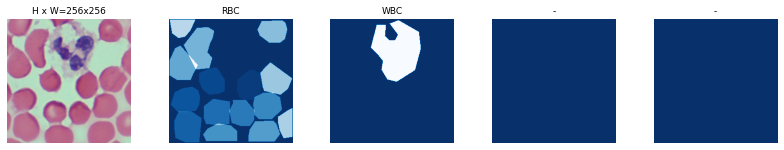

6
/content/ImageSegmentation/images/train/image-11.png


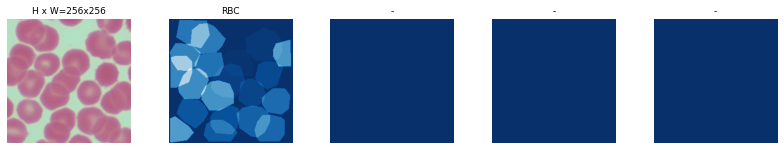

7
/content/ImageSegmentation/images/train/image-12.png


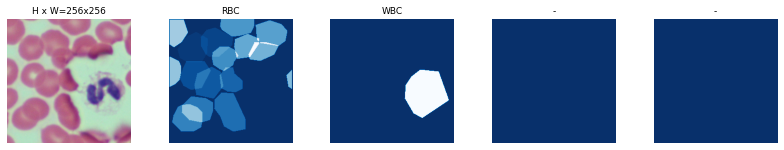

3
/content/ImageSegmentation/images/train/image-7.png


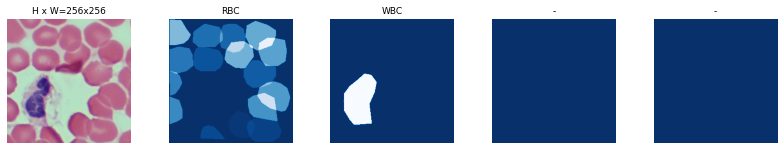

In [13]:
# Análisis de la muestra
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    print(image_id)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    print(dataset.image_reference(image_id))
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  5 /content/ImageSegmentation/images/train/image-10.png
image                    shape: (256, 256, 3)         min:   83.00000  max:  228.00000  uint8
mask                     shape: (256, 256, 18)        min:    0.00000  max:    1.00000  uint8
class_ids                shape: (18,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (18, 4)               min:    0.00000  max:  256.00000  int32


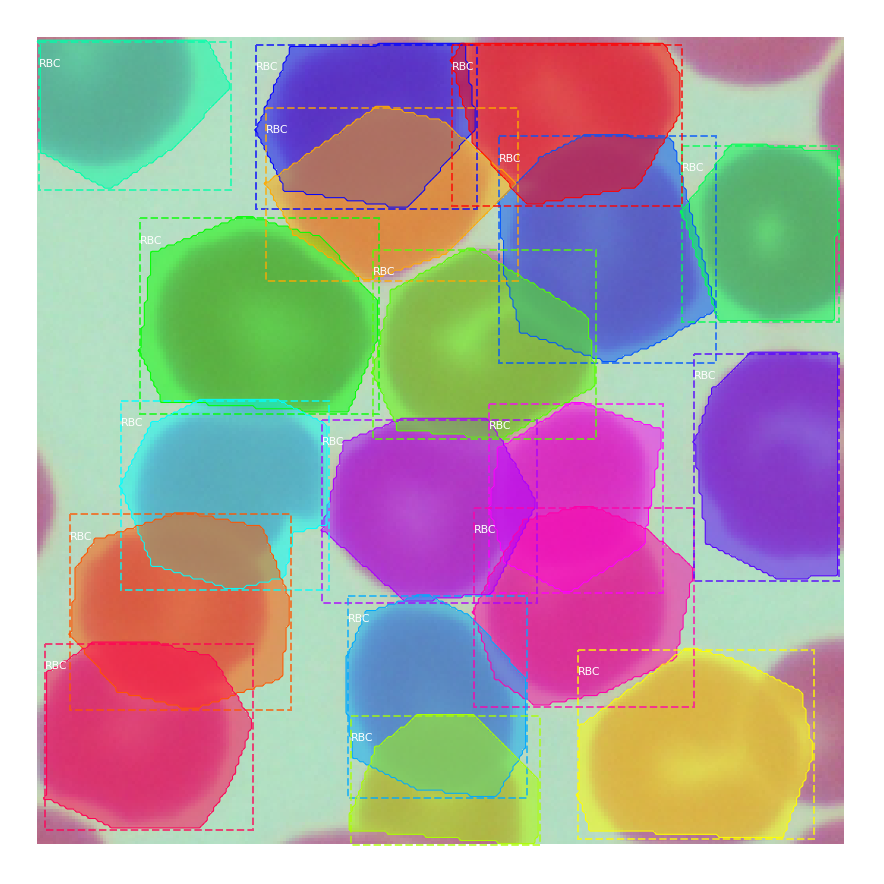

In [14]:
# Test de máscaras en imágenes de train
from mrcnn.model import log
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

# Stats de imágenes
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Imágenes e instancias
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/ImageSegmentation/logs/object20210516T2213/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_decon

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_cl

356/500 [====================>.........] - ETA: 23:54 - batch: 177.5000 - size: 1.0000 - loss: 0.9812 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.3234 - mrcnn_class_loss: 0.1969 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.2317

In [ ]:
# Clase de configuración de inferencias
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_MIN_DIM = 512
    #IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.6

inference_config = InferenceConfig()

In [ ]:
# Modelo en inferencia
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR)


In [ ]:

#model_path = os.path.join(ROOT_DIR, "/content/ImageSegmentation/logs/...")
model_path = model.find_last()

assert model_path != "", "Path al modelo entrenado"
print("Cargando modelo: ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
import skimage
import matplotlib.pyplot as plt

real_test_dir = '/content/ImageSegmentation/images/train/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    
    if img.ndim != 3:
      image = skimage.color.gray2rgb(img)
    if img.shape[-1] == 4:
      image = img[..., :3]

    print(image_path)
    img_arr = np.array(image)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))